In [1]:
import numpy as np
import gc

In [244]:
# Global Variables

timeout = 5000000
threshold = 0.001

In [256]:
def density_xor(d, stationary = True):
    reward = lambda x, y, t: ( x ^ y if (x + y) % 10 < d  else 0 ) + \
                             ( 0 if stationary else min(x, y) / (max(x, y) + 1) * t )
    return reward

def mouse_reward(x, y, t):
    return (x - y + t) % 7

class Grid: 
    def __init__(self, edge_len = 25, start = (0,0), actions = lambda x: [ 'u', 'd', 'l', 'r' ], reward_func = density_xor(5) ):
        self.start = start
        self.reward_func = reward_func
        self.edge, self.actions = edge_len, actions
        
    def transition(self, state, action, time):
        x, y = state

        if action == "u":
            state = ( (x + 1) % self.edge, y )
        elif action == "d":
            state = ( (x - 1) % self.edge, y )
        elif action == "l":
            state = ( x, (y + 1) % self.edge )
        elif action == "r":
            state = ( x, (y - 1) % self.edge )

        return self.reward_func(* state, time), state

In [257]:
grid = Grid(25, reward_func = density_xor(5, False))

In [272]:
from collections import defaultdict

class agent: 
    def __init__( self, action_selection = None, alpha = 0.1, discount = 0.1, epsilon = 0.5 ):
        self.q_vals, self.v_vals = defaultdict(lambda: 0), defaultdict(lambda: 0)
        self.xis, self.last = defaultdict(lambda: 0), defaultdict(lambda: (0,0))
        
        self.alpha, self.epsilon, self.discount = alpha, epsilon, discount
        if action_selection:
            self.action_selection = action_selection
 
    def max_action(self, state, time):
        return max(self.grid.actions(state), key = lambda x: self.q_value(state, x, time))

    def action_selection(self, state, time):
        return self.max_action(state, time)
    
    def q_value(self, state, action, time):
        return self.q_vals[(state, action)] + self.xis[(state, action)] * time
    
    def update_xi(self, state, action, reward, time):
        previous, timestamp = self.last[(state, action)]
        
        if self.v_vals[state] > 0:
            change = (reward - previous) / (time - timestamp)
            self.xis[(state, action)] = (self.alpha * change) + (1 - self.alpha) * self.xis[(state, action)]
        
        self.last[(state, action)] = (reward, time)
        return reward - ( self.xis[(state, action)] * time )
    
    def update(self, state, next_state, action, reward, time):        
        max_q_val  = self.q_vals[( next_state, self.max_action(state, time) )]
        previous, reward = self.q_vals[(state, action)], self.update_xi(state, action, reward, time)
        
        self.q_vals[(state, action)] = (1 - self.alpha) * previous + self.alpha * (reward + self.discount * (max_q_val))
        self.v_vals[state] = self.v_vals[state] + 1
        
        delta = self.q_vals[(state, action)] - previous
        return delta
        
    def play(self, grid):  
        time, state = 0, grid.start
        self.grid = grid
        
        TDEs = []
        while (self.alpha > 0.01) and (time < timeout):
            action = self.action_selection(self, state, time)
            
            reward, next_state = self.grid.transition(state, action, time)
            delta = self.update(state, next_state, action, reward, time)
            TDEs.append( abs(delta) )
            
            self.alpha = ( self.alpha * 0.999 ) if abs(delta) < threshold else min( self.alpha * 1.001, 1.0 )
            state, time = next_state, time + 1
            
        return self.validate(), time, TDEs
    
    def validate(self):
        average_reward, state = 0, self.grid.start
        for p in range( self.grid.edge ** 4 ):
            reward, state = self.grid.transition(state, self.max_action(state, p), p)   
            average_reward = average_reward + reward
        return average_reward / p

In [273]:
def epsilon_greedy(self, state, time, epsilon = None):
    max_action = max(self.grid.actions(state), key = lambda x: self.q_value(state, x, time))
    return max_action if np.random.random() < (epsilon or self.epsilon) else np.random.choice( self.grid.actions(state) )

def softmax(self, state, time, beta = 1):
    q_vals = np.array([ self.q_value(state, a, time) for a in self.grid.actions(state) ])    
    softmax = np.exp((q_vals * beta)) / (np.sum(np.exp(q_vals * beta)))
    return np.random.choice( self.grid.actions(state), p = softmax )

def boltzmann(self, state, time, epsilon = None):
    return softmax(self, state, time, (epsilon or self.epsilon))
    
def mixture(self, state, time, epsilon = None):
    return softmax(self, state, time) if np.random.random() < (epsilon or self.epsilon) else np.random.choice( self.grid.actions(state) )

action_selection_strategies = [ epsilon_greedy, boltzmann, mixture ]

183549.70754617706 32090
0.2377812398686491


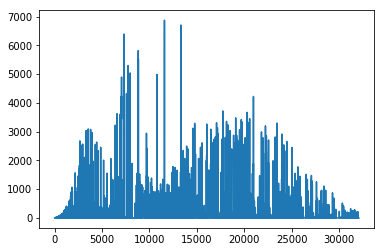

In [274]:
import matplotlib.pyplot as plt
%matplotlib inline

_agent = agent( epsilon_greedy )
r, i, t = _agent.play( grid )

print(r, i)

difference = [ (min(* state) / (max(* state) + 1)) - _agent.xis[(state, action)] for state, action in _agent.xis ]
print( np.sqrt( np.mean( np.array(difference) ** 2 ) ) )

plt.plot(range(i), t)
plt.show()

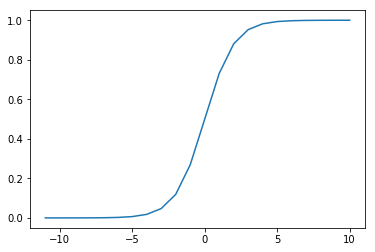

In [197]:
def sigmoid(x, rho = 1):
    return (np.exp(rho * x) / (1 + np.exp(rho * x)))

plt.plot( range(-11, 11), [ sigmoid(i) for i in range(-11, 11) ] )
plt.show()

In [9]:
class inhomogenous_agent(agent):
    def __init__( self, action_selection = None, alpha = 0.1, discount = 0.1, rhos = (1, 1), lags = -1 ):
        super().__init__( action_selection, alpha, discount )

        self.rho1, self.rho2 = rhos
        self.TDES, self.L = [], lags
            
    def action_selection(self, state, randomness = None):
        return super().action_selection(state, self.distribution(state))
    
    def update(self, state, next_state, action, reward, time):
        delta = super().update( state, next_state, action, reward, time )
        self.TDES.append(delta)
        
        if self.L > -1 and len(self.TDES) > self.L:
            self.TDES.pop(0)
        return delta
    
    def phi_explore(self, state):
        state_len = len(self.q_vals) + 1
        state_sum = np.sum([ self.v_vals[i] for i in self.v_vals ]) + 1
        return sigmoid((1 / state_len) - ( self.v_vals[state] / state_sum ), self.rho1)
    
    def phi_exploit(self, state):
        relative = self.TDES[-1] / np.sum(self.TDES)
        return sigmoid(1 - (relative * len(self.TDES)), self.rho2)

    def distribution(self, state):
        epsilon = self.phi_exploit(state)
        return epsilon / (epsilon + self.phi_explore(state))

0.2846007238825473 4117 5.1474782631202225e-05


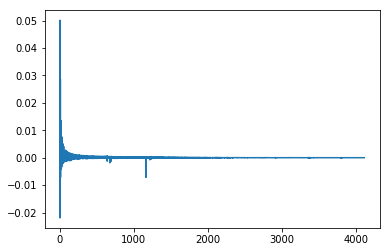

In [24]:
_agent = inhomogenous_agent( mixture )
r, i, t = _agent.play( grid )

print(r, i, _agent.xi)

plt.plot(range(i), t)
plt.show()

In [ ]:
from itertools import product
from random import sample

alpha = discount = density = np.arange(0.1, 1, 0.1)
size, density = np.arange(5, 25, 5), np.arange(0.1, 1, 0.1)

parameters = list( product(alpha, discount, size, density) )
parameters = sample( parameters, len(parameters) // 10 )

In [ ]:
from tqdm import tqdm
import ray

@ray.remote
def run_scenario(strategy, parameter_set, inhomogenous):
    size, density = parameter_set.pop(2), parameter_set.pop(2)
    current_grid = Grid(size, reward_func = density_xor(density))
    
    current_agent = inhomogenous_agent(strategy, *parameter_set) if inhomogenous else agent(strategy, *parameter_set)
    rewards, iterations = current_agent.play( current_grid )
    return [ rewards, iterations ]
    
def test_agent(strategy, inhomogenous = False):
    agent_parameters = product( np.arange(0, 10, 0.5), np.arange(0, 10, 0.5), range(-1, 10) ) if inhomogenous else product( np.arange(0.1, 1, 0.1) )
    total_parameters = [ [*a, *b] for a, b in product( parameters, agent_parameters ) ]
    
    scenario = lambda x: run_scenario.remote(strategy, x, inhomogenous)
    results  = [ scenario(x) for x in tqdm(total_parameters) ]
    results  = ray.get( results )
    
    exogenous  = np.array( total_parameters, dtype = np.float32 )
    endogenous = np.array( results, dtype = np.float32 )

    endo_filename = descriptor + 'inhomogenous_endo.npy' if inhomogenous else '_endo.npy'
    exog_filename = descriptor + 'inhomogenous_exog.npy' if inhomogenous else '_exog.npy'

    np.save(endo_filename, endogenous)
    np.save(exog_filename, exogenous)
    
    gc.collect()

In [ ]:
ray.init()

for strategy in action_selection_strategies:
    test_agent(strategy, pool)
    test_agent(strategy, pool, True)

In [ ]:
def B(d1, d2):
    assert len(d1) == len(d2)
    return sum([ np.sqrt(d1[i] * d2[i]) for i in range(len(d1)) ])

def KL(d1, d2):
    assert len(d1) == len(d2)
    return sum([ d1[i] * np.log( d1[i] / d2[i] ) for i in range(len(d1)) ])

def normalize(d):
    d = d + abs(min(d))
    return [ i / sum(d) for i in d ]

def RMSE_q_values(agent, state):
    q_values = [ agent.q_vals[( state, a)] for a in agent.grid.actions(state) ]
    
    next_state = [ agent.grid.transition(state, a)[1] for a in agent.grid.actions(state) ]
    true_rwrds = [ ((x * y) + (x - 25)) / 25 for x, y in next_state ]
    
    return np.linalg.norm(np.array(q_values) - np.array(true_rwrds))

def RMSE_total(agent):
    return np.sqrt(np.mean([ RMSE_q_values(agent, (i, j)) for i in range(agent.grid.edge) for j in range(agent.grid.edge) ]))

In [ ]:
X, Y, Z, T = [], [], [], []

N = 1000
f = B #KL

for epsilon in tqdm(range(1, 11)):
    beta = epsilon / 10
    a, b, c = 0, 0, 0
    
    for i in range(N):
        rand_vec = np.random.random( 25 * 25 )
    
        boltz = np.exp(rand_vec * beta)/np.sum(np.exp(rand_vec * beta))
        mixy  = (1 - beta) *  np.exp(rand_vec)/np.sum(np.exp(rand_vec)) + (beta) * 1 / (rand_vec.shape[0])
        greed = (1 - beta) * (rand_vec == max(rand_vec)).astype("int")  + (beta) * 1 / (rand_vec.shape[0])
        
        a = a + f(boltz, mixy)
        b = b + f(boltz, greed)
        c = c + f(mixy, greed)

    X += [(10 - epsilon) / 10]
    Y += [a / N]
    Z += [b / N]
    T += [c / N]

plt.plot(X, Y, "g")
plt.plot(X, Z, "r")
plt.plot(X, T, "b")
plt.show()